In [1]:
import os
import sys

cwd0 = './config/'
sys.path.append(cwd0)

import visualID_Eng as vID
from visualID_Eng import color
vID.init(cwd0)

**Start at:** Wednesday 17 May 2023, 16:08:03  
**Hostname:** insa-12842 (Linux)

<p style="text-align: center"><img width="800px" src="./config/svg/PytChemBanner.svg" style="margin-left:auto; margin-right:auto"/></p>

# Prediction of the solubility of CO<sub>2</sub> in ionic liquids with the Support Vector Regression (SVR) method

<div class="intro">

<b>Reference</b>: 
Z. Song, H. Shi, X. Zhang & T. Zhou (**2020**), Prediction of CO<sub>2</sub> solubility in ionic liquids using machine learning methods, [<i>Chem. Eng. Sci.</i> <b>223</b>: 115752](https://www.doi.org/10.1016/j.ces.2020.115752) 
<br>
<p style="text-align: center"><img width="650px" src="./DS4B-CO2-images/AbstractANNCO2-SongEtal.png" style="margin-left:auto; margin-right:auto" id="img_AbstractSong"></p>
<br>
The main results are graphically reported below.
<br>
<p style="text-align: center"><img width="900px" src="./DS4B-CO2-images/SVRCO2-SongEtal-Results-C.png" style="margin-left:auto; margin-right:auto" id="img_ResultsSong"></p>
<br>
<span style="font-weight:bold">The goal of this tutorial is to reproduce the SVM part of this article. </span>

</div>

In [2]:
%matplotlib inline

import numpy as np  # to apply mathematical operations on arrays and matrices
import matplotlib as mp # graphical representation and visualization of data
import matplotlib.pyplot as plt
import pandas as pd   # used for data analysis, works with tabular data (.csv)
import seaborn as sb  # statistical graphics

import os,sys
from IPython.display import display


## **1.** Basic data analysis and visualization

### **1.a.** Read the database

In [3]:
dataCO2f='./DS4B-CO2-data/dataCO2.csv'
dataCO2=pd.read_csv(dataCO2f,sep=";",header=0)
display(dataCO2)
# describe() generates descriptive statistics
display(dataCO2.describe().style.format("{0:.2f}"))

,IL,cation,anion,x_CO2,T (K),P (bar),[CH3],[CH2],[CH],[OCH2],...,[MeSO3],[TfO],[NfO],[TDfO],[TOS],[C12PhSO3],[DMPO4],[DEPO4],[DBPO4],[methide]
0,[BMIM][BF4],[BMIM],[BF4],0.610,363.15,246.00,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0
1,[BMIM][BF4],[BMIM],[BF4],0.500,383.15,235.00,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0
2,[BMIM][BF4],[BMIM],[BF4],0.610,353.15,223.30,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0
3,[BMIM][BF4],[BMIM],[BF4],0.500,373.15,198.00,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0
4,[BMIM][BF4],[BMIM],[BF4],0.610,343.15,188.50,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10111,[HMIM][Tf2N],[HMIM],[Tf2N],0.592,298.15,35.86,1,5,0,0,...,0,0,0,0,0,0,0,0,0,0
10112,[HMIM][Tf2N],[HMIM],[Tf2N],0.239,343.15,27.54,1,5,0,0,...,0,0,0,0,0,0,0,0,0,0
10113,[HMIM][Tf2N],[HMIM],[Tf2N],0.396,298.15,20.15,1,5,0,0,...,0,0,0,0,0,0,0,0,0,0
10114,[HMIM][Tf2N],[HMIM],[Tf2N],0.140,343.15,17.93,1,5,0,0,...,0,0,0,0,0,0,0,0,0,0


,x_CO2,T (K),P (bar),[CH3],[CH2],[CH],[OCH2],[OCH3],[CF2],[CF3],[OH],CH=CH,CH=CH2,[Im13],[MIm],[MMIM],[Py],[MPy],[MPyrro],[MPip],[NH3],[NH2],[NH],[N],[P],[S],[BF4],[Cl],[DCA],[NO3],[PF6],[SCN],[TCB],[C(CN)3],[HSO4],[FSA],[Tf2N],[BETA],[FOR],[TFA],[C3F7CO2],[MeSO4],[EtSO4],[MDEGSO4],[MeSO3],[TfO],[NfO],[TDfO],[TOS],[C12PhSO3],[DMPO4],[DEPO4],[DBPO4],[methide]
count,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00
mean,0.33,325.27,54.21,1.18,4.72,0.02,0.02,0.04,0.04,0.01,0.06,0.00,0.00,0.01,0.77,0.01,0.00,0.01,0.09,0.00,0.00,0.01,0.00,0.02,0.05,0.00,0.11,0.02,0.02,0.02,0.11,0.02,0.01,0.07,0.00,0.01,0.43,0.00,0.01,0.01,0.00,0.02,0.01,0.01,0.02,0.05,0.01,0.01,0.00,0.01,0.00,0.01,0.00,0.00
std,0.24,25.24,76.66,0.96,5.48,0.25,0.16,0.20,0.39,0.10,0.28,0.06,0.06,0.10,0.42,0.08,0.07,0.11,0.29,0.06,0.07,0.09,0.06,0.16,0.23,0.06,0.31,0.12,0.15,0.12,0.31,0.14,0.08,0.26,0.04,0.11,0.49,0.03,0.11,0.11,0.05,0.13,0.11,0.10,0.15,0.23,0.09,0.08,0.06,0.10,0.03,0.07,0.04,0.05
min,0.00,243.20,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.14,308.15,10.00,1.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.30,323.15,26.80,1.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.51,342.59,64.76,1.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,0.95,453.15,499.90,7.00,28.00,3.00,2.00,1.00,5.00,1.00,3.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


### **1.b.** Data distribution

       x_CO2
[CH3]       
0        855
1       8350
2        108
3         92
4        639
7         72


array([[<Axes: title={'center': '[CH3]'}>]], dtype=object)

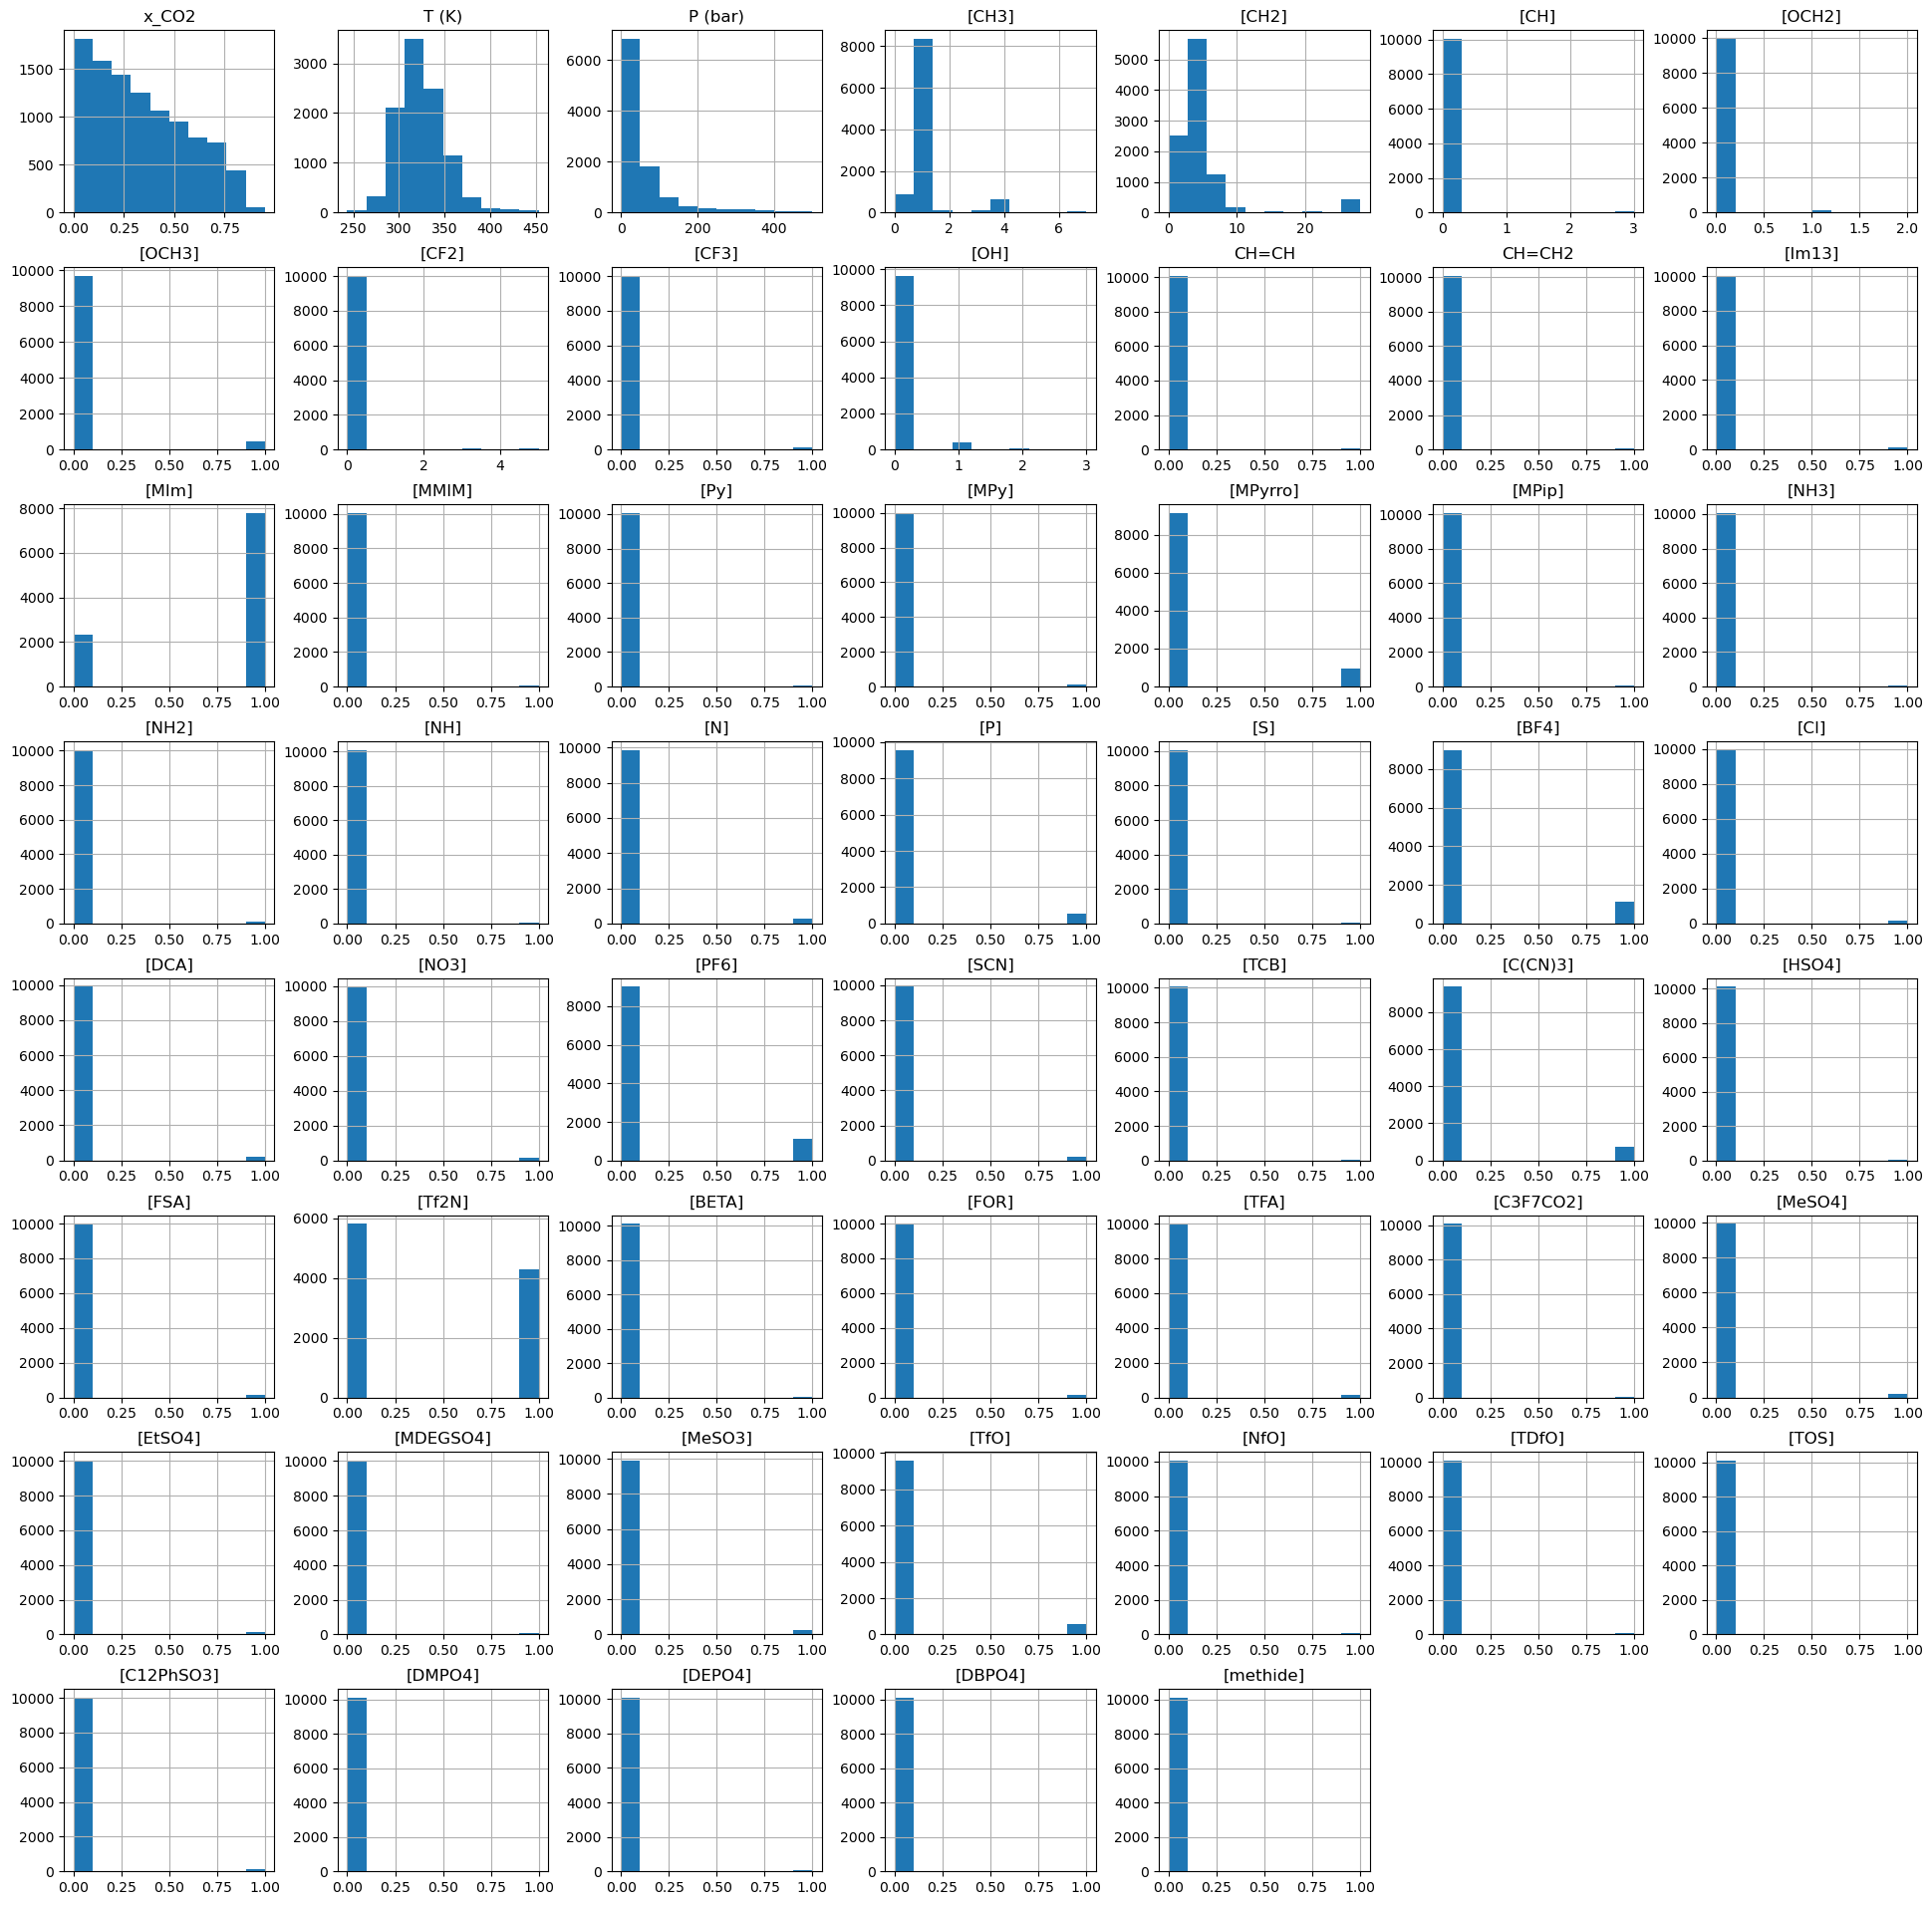

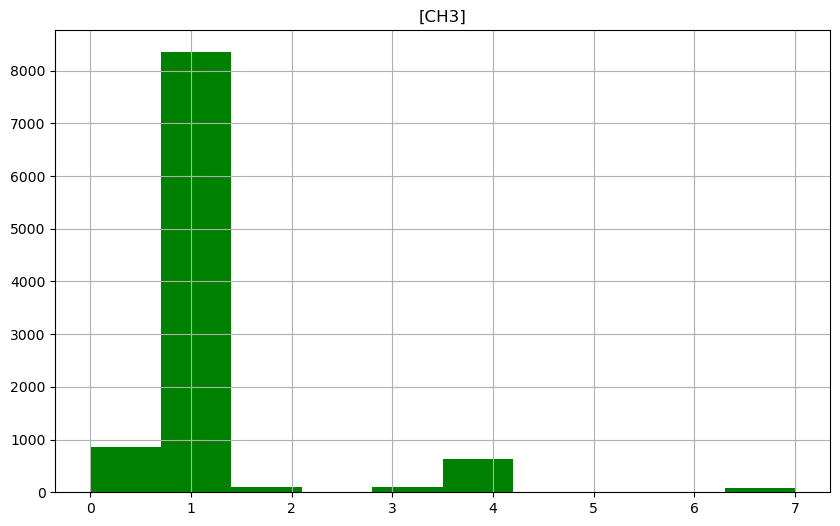

In [4]:
dataCO2.hist(figsize=(24,24))
print(dataCO2[["x_CO2", "[CH3]"]].groupby("[CH3]").count())
dataCO2.hist("[CH3]",figsize=(10,6),facecolor='g')

### **1.c.** Data standardization

<div class="intro">

Data will now be standardized, using ```StandardScaler``` from the ```preprocessing``` package provided by the ```scikit learn``` library.

In general terms, standardization is useful when features of the input data have large differences in their ranges of values. The standardized data have mean value equal to 0 and standard deviation equal to 1.

The dataframe is separated into two subsets:
- <code>X</code> the features; given as input to the program
- <code>y</code> the values we want to predict

</div>
<br>
<div class="rq">
    
```y```  is not necessarily standardized in this case, the solubility values vary within a range from 0 to 1</div>

In [5]:
X=dataCO2.drop(['IL','cation','anion','x_CO2'],axis=1)
y = dataCO2['x_CO2']
X_Tmp = X.copy() # for plotting purpose
print("X before standardization")
display(X)
display(X.describe().style.format("{0:.2f}").set_caption("X before standardization :"))
# print("y before standardization")
# display(y)

from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
scaler.fit(X.values)
Xsc = scaler.transform(X.values)
X = pd.DataFrame(Xsc, index=X.index, columns=X.columns)

print("scaling done")

print("X after standardization")
display(X)
display(X.describe().style.format("{0:.2f}").set_caption("X after standardization (with scikit-learn):"))

print("y")
display(y)

X before standardization


,T (K),P (bar),[CH3],[CH2],[CH],[OCH2],[OCH3],[CF2],[CF3],[OH],...,[MeSO3],[TfO],[NfO],[TDfO],[TOS],[C12PhSO3],[DMPO4],[DEPO4],[DBPO4],[methide]
0,363.15,246.00,1,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,383.15,235.00,1,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,353.15,223.30,1,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,373.15,198.00,1,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,343.15,188.50,1,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10111,298.15,35.86,1,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10112,343.15,27.54,1,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10113,298.15,20.15,1,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10114,343.15,17.93,1,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,T (K),P (bar),[CH3],[CH2],[CH],[OCH2],[OCH3],[CF2],[CF3],[OH],CH=CH,CH=CH2,[Im13],[MIm],[MMIM],[Py],[MPy],[MPyrro],[MPip],[NH3],[NH2],[NH],[N],[P],[S],[BF4],[Cl],[DCA],[NO3],[PF6],[SCN],[TCB],[C(CN)3],[HSO4],[FSA],[Tf2N],[BETA],[FOR],[TFA],[C3F7CO2],[MeSO4],[EtSO4],[MDEGSO4],[MeSO3],[TfO],[NfO],[TDfO],[TOS],[C12PhSO3],[DMPO4],[DEPO4],[DBPO4],[methide]
count,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00
mean,325.27,54.21,1.18,4.72,0.02,0.02,0.04,0.04,0.01,0.06,0.00,0.00,0.01,0.77,0.01,0.00,0.01,0.09,0.00,0.00,0.01,0.00,0.02,0.05,0.00,0.11,0.02,0.02,0.02,0.11,0.02,0.01,0.07,0.00,0.01,0.43,0.00,0.01,0.01,0.00,0.02,0.01,0.01,0.02,0.05,0.01,0.01,0.00,0.01,0.00,0.01,0.00,0.00
std,25.24,76.66,0.96,5.48,0.25,0.16,0.20,0.39,0.10,0.28,0.06,0.06,0.10,0.42,0.08,0.07,0.11,0.29,0.06,0.07,0.09,0.06,0.16,0.23,0.06,0.31,0.12,0.15,0.12,0.31,0.14,0.08,0.26,0.04,0.11,0.49,0.03,0.11,0.11,0.05,0.13,0.11,0.10,0.15,0.23,0.09,0.08,0.06,0.10,0.03,0.07,0.04,0.05
min,243.20,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,308.15,10.00,1.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,323.15,26.80,1.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,342.59,64.76,1.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,453.15,499.90,7.00,28.00,3.00,2.00,1.00,5.00,1.00,3.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


scaling done
X after standardization


,T (K),P (bar),[CH3],[CH2],[CH],[OCH2],[OCH3],[CF2],[CF3],[OH],...,[MeSO3],[TfO],[NfO],[TDfO],[TOS],[C12PhSO3],[DMPO4],[DEPO4],[DBPO4],[methide]
0,1.500742,2.501854,-0.183557,-0.314389,-0.084667,-0.120283,-0.209673,-0.097226,-0.100423,-0.204298,...,-0.152529,-0.240932,-0.08815,-0.076593,-0.059761,-0.105809,-0.034462,-0.075277,-0.04222,-0.04561
1,2.293124,2.358359,-0.183557,-0.314389,-0.084667,-0.120283,-0.209673,-0.097226,-0.100423,-0.204298,...,-0.152529,-0.240932,-0.08815,-0.076593,-0.059761,-0.105809,-0.034462,-0.075277,-0.04222,-0.04561
2,1.104551,2.205733,-0.183557,-0.314389,-0.084667,-0.120283,-0.209673,-0.097226,-0.100423,-0.204298,...,-0.152529,-0.240932,-0.08815,-0.076593,-0.059761,-0.105809,-0.034462,-0.075277,-0.04222,-0.04561
3,1.896933,1.875695,-0.183557,-0.314389,-0.084667,-0.120283,-0.209673,-0.097226,-0.100423,-0.204298,...,-0.152529,-0.240932,-0.08815,-0.076593,-0.059761,-0.105809,-0.034462,-0.075277,-0.04222,-0.04561
4,0.708360,1.751768,-0.183557,-0.314389,-0.084667,-0.120283,-0.209673,-0.097226,-0.100423,-0.204298,...,-0.152529,-0.240932,-0.08815,-0.076593,-0.059761,-0.105809,-0.034462,-0.075277,-0.04222,-0.04561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10111,-1.074499,-0.239419,-0.183557,0.050373,-0.084667,-0.120283,-0.209673,-0.097226,-0.100423,-0.204298,...,-0.152529,-0.240932,-0.08815,-0.076593,-0.059761,-0.105809,-0.034462,-0.075277,-0.04222,-0.04561
10112,0.708360,-0.347953,-0.183557,0.050373,-0.084667,-0.120283,-0.209673,-0.097226,-0.100423,-0.204298,...,-0.152529,-0.240932,-0.08815,-0.076593,-0.059761,-0.105809,-0.034462,-0.075277,-0.04222,-0.04561
10113,-1.074499,-0.444355,-0.183557,0.050373,-0.084667,-0.120283,-0.209673,-0.097226,-0.100423,-0.204298,...,-0.152529,-0.240932,-0.08815,-0.076593,-0.059761,-0.105809,-0.034462,-0.075277,-0.04222,-0.04561
10114,0.708360,-0.473315,-0.183557,0.050373,-0.084667,-0.120283,-0.209673,-0.097226,-0.100423,-0.204298,...,-0.152529,-0.240932,-0.08815,-0.076593,-0.059761,-0.105809,-0.034462,-0.075277,-0.04222,-0.04561


,T (K),P (bar),[CH3],[CH2],[CH],[OCH2],[OCH3],[CF2],[CF3],[OH],CH=CH,CH=CH2,[Im13],[MIm],[MMIM],[Py],[MPy],[MPyrro],[MPip],[NH3],[NH2],[NH],[N],[P],[S],[BF4],[Cl],[DCA],[NO3],[PF6],[SCN],[TCB],[C(CN)3],[HSO4],[FSA],[Tf2N],[BETA],[FOR],[TFA],[C3F7CO2],[MeSO4],[EtSO4],[MDEGSO4],[MeSO3],[TfO],[NfO],[TDfO],[TOS],[C12PhSO3],[DMPO4],[DEPO4],[DBPO4],[methide]
count,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00
mean,0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-3.25,-0.71,-1.22,-0.86,-0.08,-0.12,-0.21,-0.10,-0.10,-0.20,-0.06,-0.06,-0.10,-1.83,-0.08,-0.07,-0.11,-0.32,-0.06,-0.07,-0.09,-0.06,-0.16,-0.24,-0.06,-0.35,-0.13,-0.15,-0.13,-0.35,-0.14,-0.08,-0.28,-0.04,-0.12,-0.86,-0.03,-0.12,-0.11,-0.05,-0.13,-0.11,-0.10,-0.15,-0.24,-0.09,-0.08,-0.06,-0.11,-0.03,-0.08,-0.04,-0.05
25%,-0.68,-0.58,-0.18,-0.31,-0.08,-0.12,-0.21,-0.10,-0.10,-0.20,-0.06,-0.06,-0.10,0.55,-0.08,-0.07,-0.11,-0.32,-0.06,-0.07,-0.09,-0.06,-0.16,-0.24,-0.06,-0.35,-0.13,-0.15,-0.13,-0.35,-0.14,-0.08,-0.28,-0.04,-0.12,-0.86,-0.03,-0.12,-0.11,-0.05,-0.13,-0.11,-0.10,-0.15,-0.24,-0.09,-0.08,-0.06,-0.11,-0.03,-0.08,-0.04,-0.05
50%,-0.08,-0.36,-0.18,-0.31,-0.08,-0.12,-0.21,-0.10,-0.10,-0.20,-0.06,-0.06,-0.10,0.55,-0.08,-0.07,-0.11,-0.32,-0.06,-0.07,-0.09,-0.06,-0.16,-0.24,-0.06,-0.35,-0.13,-0.15,-0.13,-0.35,-0.14,-0.08,-0.28,-0.04,-0.12,-0.86,-0.03,-0.12,-0.11,-0.05,-0.13,-0.11,-0.10,-0.15,-0.24,-0.09,-0.08,-0.06,-0.11,-0.03,-0.08,-0.04,-0.05
75%,0.69,0.14,-0.18,0.05,-0.08,-0.12,-0.21,-0.10,-0.10,-0.20,-0.06,-0.06,-0.10,0.55,-0.08,-0.07,-0.11,-0.32,-0.06,-0.07,-0.09,-0.06,-0.16,-0.24,-0.06,-0.35,-0.13,-0.15,-0.13,-0.35,-0.14,-0.08,-0.28,-0.04,-0.12,1.16,-0.03,-0.12,-0.11,-0.05,-0.13,-0.11,-0.10,-0.15,-0.24,-0.09,-0.08,-0.06,-0.11,-0.03,-0.08,-0.04,-0.05
max,5.07,5.81,6.05,4.25,11.81,12.23,4.77,12.61,9.96,10.49,15.49,16.07,9.63,0.55,12.44,14.48,9.37,3.09,16.73,14.48,11.34,16.97,6.27,4.20,16.07,2.84,7.99,6.71,7.89,2.84,6.90,12.73,3.52,27.88,8.60,1.16,30.31,8.66,8.90,18.98,7.47,9.37,9.72,6.56,4.15,11.34,13.06,16.73,9.45,29.02,13.28,23.69,21.93


y


0        0.610
1        0.500
2        0.610
3        0.500
4        0.610
         ...  
10111    0.592
10112    0.239
10113    0.396
10114    0.140
10115    0.139
Name: x_CO2, Length: 10116, dtype: float64

/tmp/ipykernel_20057/2043957100.py:13: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax00=plt.subplot(gs[0,0], title="Before standardization")


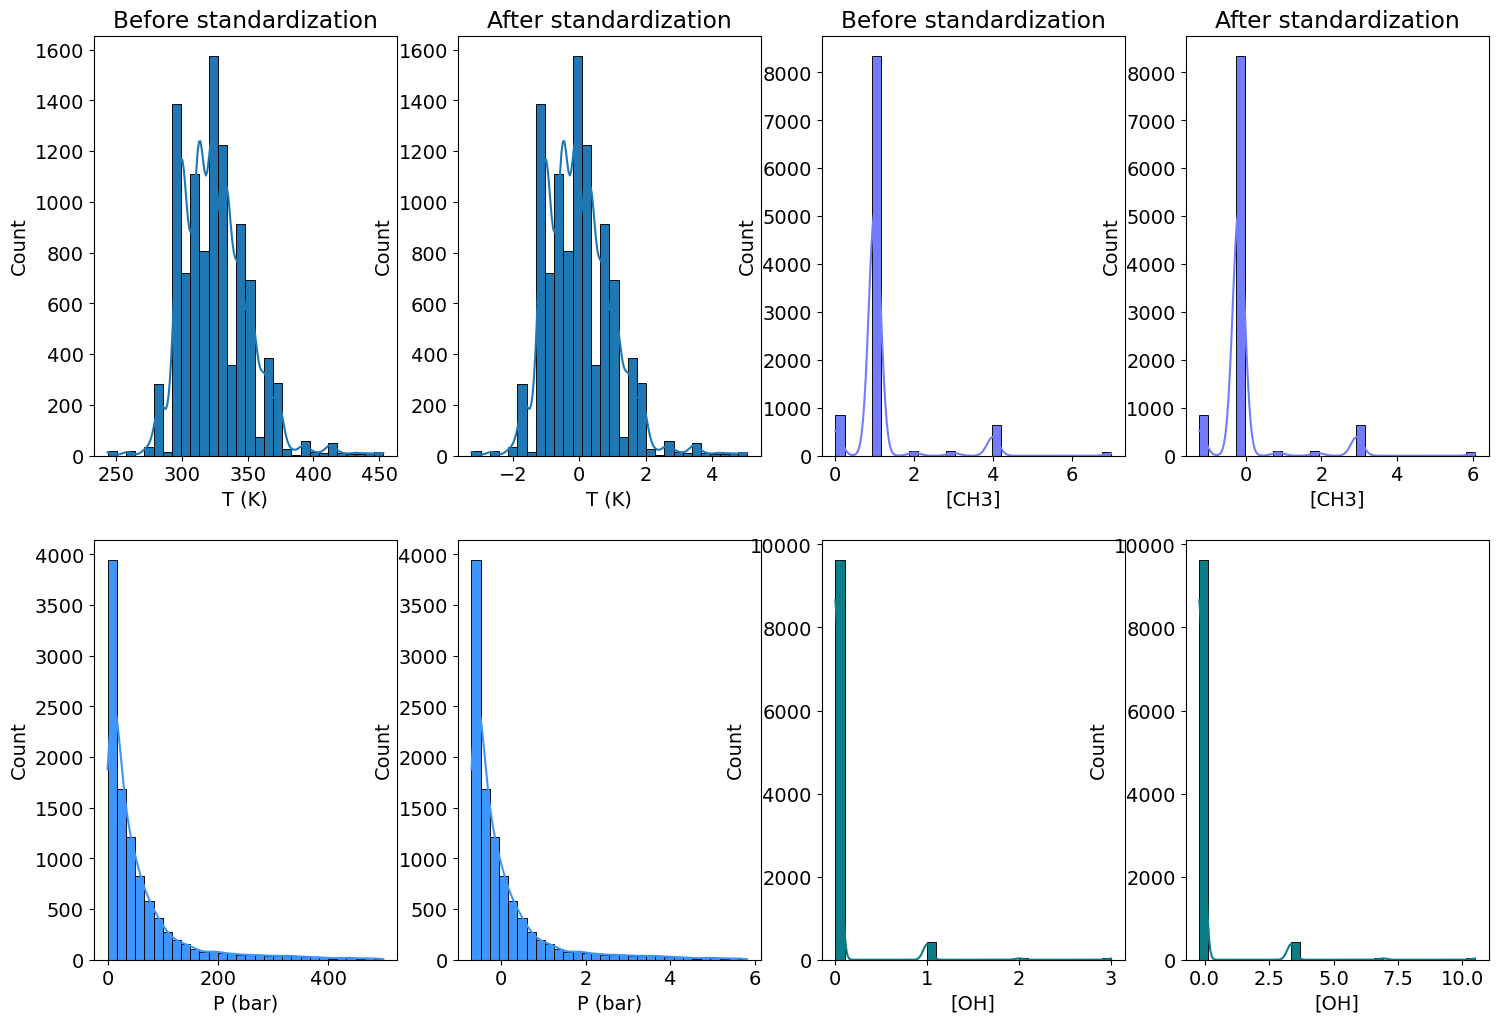

In [6]:
#######################################################################################
# graphic representation of the previous tables
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator

nbins=30
fig = plt.figure(figsize=(18, 12))
plt.rcParams["font.size"] = (14) #font size
plt.tick_params(axis='x',labelsize = 16)
plt.tick_params(axis='y',labelsize = 12)
gs = gridspec.GridSpec(2, 4, height_ratios=[1, 1], width_ratios=[1, 1, 1, 1])

ax00=plt.subplot(gs[0,0], title="Before standardization")
fig00=sb.histplot(data=X_Tmp,x="T (K)", bins=nbins, kde=True, color="#1f77b4", alpha=1.0)
ax10=plt.subplot(gs[1,0])
fig10=sb.histplot(data=X_Tmp,x="P (bar)", bins=nbins, kde=True, color="#3e95ff", alpha=1.0)
ax01=plt.subplot(gs[0,1], title="After standardization")
fig01=sb.histplot(data=X,x="T (K)", bins=nbins, kde=True, color="#1f77b4", alpha=1.0)
ax11=plt.subplot(gs[1,1])
fig11=sb.histplot(data=X,x="P (bar)", bins=nbins, kde=True, color="#3e95ff", alpha=1.0)

ax02=plt.subplot(gs[0,2], title="Before standardization")
fig02=sb.histplot(data=X_Tmp,x="[CH3]", bins=nbins, kde=True, color="#737cff", alpha=1.0)
ax12=plt.subplot(gs[1,2])
fig12=sb.histplot(data=X_Tmp,x="[OH]", bins=nbins, kde=True, color="#0a7d87", alpha=1.0)
ax03=plt.subplot(gs[0,3], title="After standardization")
fig03=sb.histplot(data=X,x="[CH3]", bins=nbins, kde=True, color="#737cff", alpha=1.0)
ax13=plt.subplot(gs[1,3])
fig13=sb.histplot(data=X,x="[OH]", bins=nbins, kde=True, color="#0a7d87", alpha=1.0)


<div class="intro">

<code>X</code> and <code>y</code> are furtherly split into training and test sets</div>

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [8]:
X_train

,T (K),P (bar),[CH3],[CH2],[CH],[OCH2],[OCH3],[CF2],[CF3],[OH],...,[MeSO3],[TfO],[NfO],[TDfO],[TOS],[C12PhSO3],[DMPO4],[DEPO4],[DBPO4],[methide]
8698,-0.084022,-0.681135,-0.183557,-0.496769,-0.084667,-0.120283,-0.209673,-0.097226,-0.100423,-0.204298,...,-0.152529,-0.240932,-0.08815,-0.076593,-0.059761,-0.105809,-0.034462,-0.075277,-0.04222,-0.04561
1961,-1.074103,-0.576762,-1.223230,-0.496769,-0.084667,-0.120283,-0.209673,7.527123,9.957832,-0.204298,...,-0.152529,-0.240932,-0.08815,-0.076593,-0.059761,-0.105809,-0.034462,-0.075277,-0.04222,-0.04561
9374,-0.084022,0.606418,-0.183557,0.050373,-0.084667,-0.120283,-0.209673,-0.097226,-0.100423,-0.204298,...,-0.152529,-0.240932,-0.08815,-0.076593,-0.059761,-0.105809,-0.034462,-0.075277,-0.04222,-0.04561
3953,-1.260709,-0.428049,-0.183557,-0.314389,-0.084667,-0.120283,-0.209673,-0.097226,-0.100423,-0.204298,...,-0.152529,-0.240932,-0.08815,-0.076593,-0.059761,-0.105809,-0.034462,-0.075277,-0.04222,-0.04561
1883,-0.084814,0.077444,-0.183557,-0.314389,-0.084667,-0.120283,-0.209673,-0.097226,-0.100423,-0.204298,...,-0.152529,-0.240932,-0.08815,-0.076593,-0.059761,-0.105809,-0.034462,-0.075277,-0.04222,-0.04561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2895,-1.668785,-0.615897,-0.183557,-0.314389,-0.084667,-0.120283,-0.209673,-0.097226,-0.100423,-0.204298,...,-0.152529,-0.240932,-0.08815,-0.076593,-0.059761,-0.105809,-0.034462,-0.075277,-0.04222,-0.04561
7813,-0.084022,-0.589820,1.895791,-0.314389,-0.084667,-0.120283,-0.209673,-0.097226,-0.100423,-0.204298,...,-0.152529,-0.240932,-0.08815,-0.076593,-0.059761,-0.105809,-0.034462,-0.075277,-0.04222,-0.04561
905,-0.084022,-0.661424,-0.183557,-0.314389,-0.084667,-0.120283,-0.209673,-0.097226,-0.100423,-0.204298,...,-0.152529,-0.240932,-0.08815,-0.076593,-0.059761,-0.105809,-0.034462,-0.075277,-0.04222,-0.04561
5192,0.708360,-0.626463,-1.223230,-0.496769,-0.084667,-0.120283,-0.209673,-0.097226,-0.100423,3.358938,...,-0.152529,-0.240932,-0.08815,-0.076593,-0.059761,-0.105809,-0.034462,-0.075277,-0.04222,-0.04561


In [15]:
X_test

,T (K),P (bar),[CH3],[CH2],[CH],[OCH2],[OCH3],[CF2],[CF3],[OH],...,[MeSO3],[TfO],[NfO],[TDfO],[TOS],[C12PhSO3],[DMPO4],[DEPO4],[DBPO4],[methide]
6020,-0.876404,-0.624220,-0.183557,0.415134,-0.084667,-0.120283,-0.209673,-0.097226,-0.100423,-0.204298,...,-0.152529,-0.240932,-0.08815,-0.076593,-0.059761,-0.105809,-0.034462,-0.075277,-0.04222,-0.04561
6201,1.507081,0.163541,2.935465,4.245129,-0.084667,-0.120283,-0.209673,-0.097226,-0.100423,-0.204298,...,-0.152529,-0.240932,-0.08815,-0.076593,-0.059761,-0.105809,-0.034462,-0.075277,-0.04222,-0.04561
8916,-0.084022,-0.642770,-1.223230,-0.314389,-0.084667,6.056288,4.769327,-0.097226,-0.100423,-0.204298,...,-0.152529,-0.240932,-0.08815,-0.076593,-0.059761,-0.105809,-0.034462,-0.075277,-0.04222,-0.04561
916,-1.074499,-0.674469,-0.183557,-0.314389,-0.084667,-0.120283,-0.209673,-0.097226,-0.100423,-0.204298,...,-0.152529,-0.240932,-0.08815,-0.076593,-0.059761,-0.105809,-0.034462,-0.075277,-0.04222,-0.04561
3484,1.896933,1.212227,-0.183557,-0.679150,-0.084667,-0.120283,-0.209673,-0.097226,-0.100423,-0.204298,...,-0.152529,-0.240932,-0.08815,-0.076593,-0.059761,-0.105809,-0.034462,-0.075277,-0.04222,-0.04561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6691,1.104551,0.517712,-0.183557,0.597515,-0.084667,-0.120283,-0.209673,-0.097226,-0.100423,-0.204298,...,-0.152529,-0.240932,-0.08815,-0.076593,-0.059761,-0.105809,-0.034462,-0.075277,-0.04222,-0.04561
5729,0.312169,0.271162,-0.183557,0.415134,-0.084667,-0.120283,-0.209673,-0.097226,-0.100423,-0.204298,...,-0.152529,-0.240932,-0.08815,-0.076593,-0.059761,-0.105809,-0.034462,-0.075277,-0.04222,-0.04561
7701,-0.480213,-0.655032,-1.223230,-0.679150,-0.084667,-0.120283,-0.209673,-0.097226,-0.100423,-0.204298,...,-0.152529,-0.240932,-0.08815,-0.076593,-0.059761,-0.105809,-0.034462,-0.075277,-0.04222,-0.04561
2489,0.763827,0.310297,-0.183557,-0.314389,-0.084667,-0.120283,-0.209673,-0.097226,-0.100423,-0.204298,...,-0.152529,4.150545,-0.08815,-0.076593,-0.059761,-0.105809,-0.034462,-0.075277,-0.04222,-0.04561


In [9]:
y_train

8698    0.0379
1961    0.2790
9374    0.4570
3953    0.5012
1883    0.6020
         ...  
2895    0.1580
7813    0.1412
905     0.0401
5192    0.0350
235     0.4576
Name: x_CO2, Length: 8092, dtype: float64

In [10]:
y_test

6020    0.2019
6201    0.6010
8916    0.0677
916     0.0458
3484    0.5700
         ...  
6691    0.6370
5729    0.6779
7701    0.0843
2489    0.4574
2951    0.0450
Name: x_CO2, Length: 2024, dtype: float64

## **2.** SVR: Concept & hyperparameters


<div class="intro">
    
The goal of the SVR is to define a hyperplane that represents the relationship between the features and the target values. It aims to capture the general trend while minimising the prediction error, rather than fitting all the data points. 
In the figure below, the red line represents the hyperplane and the dashed lines are the decision boundaries that determine the width of the hyperplane. 

<p style="text-align: center"><img width="600px" src="./DS4B-CO2-images/SVR-principle-C.png" style="margin-left:auto; margin-right:auto" id="img_SVR"></p>

**Hyperparameters:**
- <code>kernel</code> is a set of mathematical functions used to find a hyperplane in the n-dimensional space according to the input data. Common kernels include linear, polynomial, sigmoid and rbf (Radial Basis Function); the latter is used in this notebook.
- <code>epsilon</code> defines the distance between the hyperplane and the decision boundaries. All the points within this distance are considered as correct. 
- <code>C</code> determines the penalty on the error for the points that are outside the decision boundaries at a distance $\xi$.
- <code>gamma</code> captures the complexity of the data; defines how far the influence of a single training example reaches.

</div>

## **3.** Application

### **3.a.** Fitting and prediction

In [11]:
from sklearn.svm import SVR
regressor = SVR(kernel = 'rbf', epsilon=0.1, C=1.0,gamma=0.209)
regressor.fit(X_train, y_train.values.ravel())
y_pred=regressor.predict(X_test)

In [12]:
regressor = SVR(kernel = 'rbf', epsilon=0.1, C=1.0,gamma=0.209)
regressor.fit(X_train, y_train.values.ravel())
ytrain_pred=regressor.predict(X_train)

### **3.b.** Metrics

<div class="intro">

Errors calculated between the actual and predicted x_CO2 values (noted $Y$ and $\hat{Y}$ in equations below)  

MSE = Mean Squared Error  
$$\mathrm{MSE}=\frac{1}{n}\sum_{i}\left(\hat{Y}(x_{i})-Y(x_{i})\right)^{2}$$

MAE =  Mean Absolute Error 
$$\mathrm{MAE}=\frac{1}{n}\sum_{i}\left|\hat{Y}(x_{i})-Y(x_{i})\right|$$

$R^2$
</div>

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mse=mean_squared_error(y_test,y_pred)
mae=mean_absolute_error(y_test,y_pred)
r2=r2_score(y_test,y_pred)

print("MSE= ", mse)
print("MAE= ", mae)
print("R2= ", r2)

MSE=  0.003980754789607239
MAE=  0.05083276959307177
R2=  0.93104412632862


### **3.c.** Comparison between experimental and predicted CO<sub>2</sub> solubility

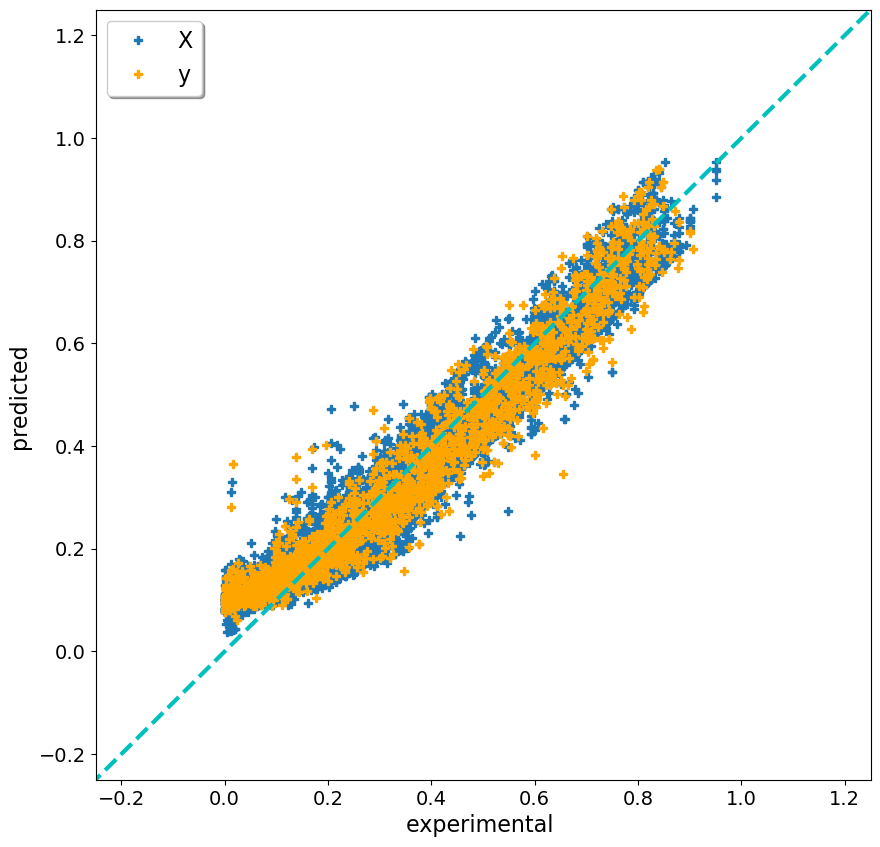

In [14]:
from pylab import *
xD=[-200,7000]
yD=[-200,7000]
fig = plt.figure(figsize=(10, 10))
plt.rcParams["font.size"] = (18) #font size
plt.tick_params(labelsize = 14)
plot(y_train,ytrain_pred,'P',color="#1f77b4",label='X')
plot(y_test,y_pred,'P',color="orange",label='y')
plot(xD,yD,'c',linestyle='--',lw=3)
xlabel('experimental ',fontsize=16)
ylabel('predicted ',fontsize=16)
xlim(-0.25,1.25);ylim(-0.25,1.25) 
#xlim(-3,150);ylim(-40,150) 
legend( shadow=True, fontsize='16')

<div class="rq">The MAE and R2 parameters seem rather good (<i>ca.</i> 0.05 and 0.93), the model reproduces the general trend for most of the data, but it fails to predict the smallest values.
<br>
<br>
<span style="color:red; font-weight:bold">Origin of this behaviour?</span>
<br>
Probably the absence of hyperparameter tuning. In the next part we aim to find the optimal <code>gamma</code>, <code>C</code> and <code>epsilon</code> values.
</div>

## **4.** Hyperparameter tuning

<div class="intro">

We explore a range of values for <code>gamma</code> varying from 0.1 to 1, for <code>C</code> varying from 0.01 to 100 and for <code>epsilon</code> varying from 0.001 to 5.
<br>
</div>
<br>
<div class="rq"> <span style="color:red; font-weight:bold">Attention</span>
<br>This can be a time-consuming process. Ideally, a larger range of values should be used for the tuning, in order to have a model that reaches the best possible predictive potential. Due to limited time, this range is restricted.
</div>

In [25]:
# Modify to test combinations in different range of values
gamma_values=[0.1,0.2,0.5,1]
c_values=[0.01,0.1,1,100]
epsilon_values=[0.001,0.01,1,5]

### **4.a.** Tuning Loop

In [26]:
gamma_list=[]
c_list=[]
epsilon_list=[]
mse_list=[]
mae_list=[]
r2_list=[]
vID.chrono_start()

# Nested loops to test all possible combinations of gamma, C and epsilon
for gam in gamma_values:
    for ce in c_values:
        for eps in epsilon_values:
            regressor = SVR(kernel = 'rbf', epsilon=eps, C=ce,gamma=gam)
            regressor.fit(X_train, y_train.values.ravel())
            y_pred=regressor.predict(X_test)
            print("gamma= ", gam)
            print("C= ", ce)
            print("Epsilon= ", eps)
            print()

            mse=mean_squared_error(y_test,y_pred)
            mae=mean_absolute_error(y_test,y_pred)
            r2=r2_score(y_test,y_pred)
            
            gamma_list.append(gam)
            c_list.append(ce)
            epsilon_list.append(eps)
            
            mse_list.append(mse)
            mae_list.append(mae)
            r2_list.append(r2)
            
vID.chrono_show()

gamma=  0.1
C=  0.01
Epsilon=  0.001

gamma=  0.1
C=  0.01
Epsilon=  0.01

gamma=  0.1
C=  0.01
Epsilon=  1

gamma=  0.1
C=  0.01
Epsilon=  5

gamma=  0.1
C=  0.1
Epsilon=  0.001

gamma=  0.1
C=  0.1
Epsilon=  0.01

gamma=  0.1
C=  0.1
Epsilon=  1

gamma=  0.1
C=  0.1
Epsilon=  5

gamma=  0.1
C=  1
Epsilon=  0.001

gamma=  0.1
C=  1
Epsilon=  0.01

gamma=  0.1
C=  1
Epsilon=  1

gamma=  0.1
C=  1
Epsilon=  5

gamma=  0.1
C=  100
Epsilon=  0.001

gamma=  0.1
C=  100
Epsilon=  0.01

gamma=  0.1
C=  100
Epsilon=  1

gamma=  0.1
C=  100
Epsilon=  5

gamma=  0.2
C=  0.01
Epsilon=  0.001

gamma=  0.2
C=  0.01
Epsilon=  0.01

gamma=  0.2
C=  0.01
Epsilon=  1

gamma=  0.2
C=  0.01
Epsilon=  5

gamma=  0.2
C=  0.1
Epsilon=  0.001

gamma=  0.2
C=  0.1
Epsilon=  0.01

gamma=  0.2
C=  0.1
Epsilon=  1

gamma=  0.2
C=  0.1
Epsilon=  5

gamma=  0.2
C=  1
Epsilon=  0.001

gamma=  0.2
C=  1
Epsilon=  0.01

gamma=  0.2
C=  1
Epsilon=  1

gamma=  0.2
C=  1
Epsilon=  5

gamma=  0.2
C=  100
Epsilon=  0.001

In [28]:
gamma_list=pd.DataFrame(gamma_list, columns=['gamma'])
c_list=pd.DataFrame(c_list, columns=['C'])
epsilon_list=pd.DataFrame(epsilon_list, columns=['epsilon'])
mse_list=pd.DataFrame(mse_list, columns=['MSE'])
mae_list=pd.DataFrame(mae_list, columns=['MAE'])
r2_list=pd.DataFrame(r2_list, columns=['R2'])

metrics=pd.concat([gamma_list,c_list,epsilon_list,mse_list,mae_list,r2_list],axis=1)

In [29]:
metrics

,gamma,C,epsilon,MSE,MAE,R2
0,0.1,0.01,0.001,0.014600,0.087975,0.747093
1,0.1,0.01,0.010,0.014614,0.088212,0.746847
2,0.1,0.01,1.000,0.074835,0.237579,-0.296312
3,0.1,0.01,5.000,0.074835,0.237579,-0.296312
4,0.1,0.10,0.001,0.006096,0.051898,0.894398
...,...,...,...,...,...,...
59,1.0,1.00,5.000,0.074835,0.237579,-0.296312
60,1.0,100.00,0.001,0.001236,0.017364,0.978594
61,1.0,100.00,0.010,0.001143,0.019192,0.980209
62,1.0,100.00,1.000,0.074835,0.237579,-0.296312


In [30]:
metrics.to_csv('./MiscCreatedInNotebooks/metrics_svr.csv', encoding='utf-8', index=False)

### **4.b.** Influence of each hyperparameter

#### ***4.b.i.*** Influence of <code>C</code>
<div class="intro">
    
We fix <code>gamma=0.2</code> and <code>epsilon=0.01</code>.
    
Within this range, the largest <code>C</code> value minimizes the error and maximizes $R^2$.</div>

[16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
[1, 5, 9, 13, 17, 21, 25, 29, 33, 37, 41, 45, 49, 53, 57, 61]
[17, 21, 25, 29]


,C,MSE,MAE,R2
17,0.01,0.013450,0.083322,0.767020
21,0.10,0.004563,0.044061,0.920965
25,1.00,0.001513,0.025441,0.973788
29,100.00,0.000821,0.017110,0.985776


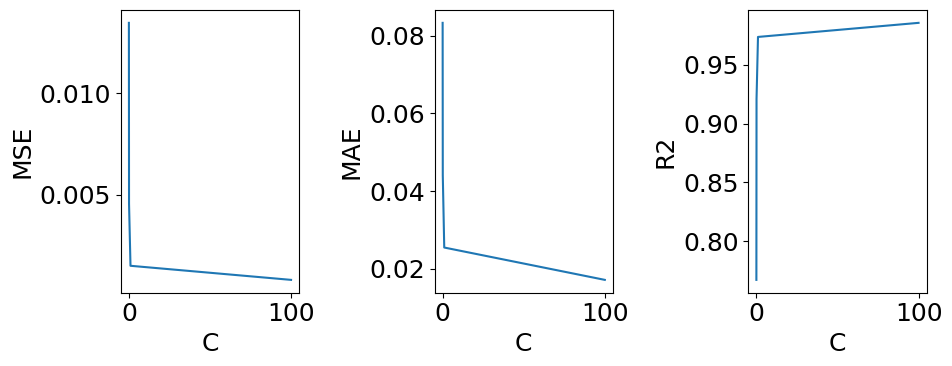

In [31]:
g=0.2
gamma_index = [i for i, x in enumerate(gamma_list.to_numpy()) if x == g]
print(gamma_index)

e=0.01
epsilon_index = [j for j, y in enumerate(epsilon_list.to_numpy()) if y == e]
print(epsilon_index)

c_index=[]
for i in gamma_index:
    for j in epsilon_index:
        if i==j:
            c_index.append(i)
print(c_index)

c_val=[]
mse_val1=[]
mae_val1=[]
r2_val1=[]
for indx in c_index:
    c_val.append(c_list.iloc[indx])
    mse_val1.append(mse_list.iloc[indx])
    mae_val1.append(mae_list.iloc[indx])
    r2_val1.append(r2_list.iloc[indx])
    
c_val1=pd.DataFrame(c_val, columns=['C'])
mse_val1=pd.DataFrame(mse_val1, columns=['MSE'])
mae_val1=pd.DataFrame(mae_val1, columns=['MAE'])
r2_val1=pd.DataFrame(r2_val1, columns=['R2'])

ge_fix=pd.concat([c_val1,mse_val1,mae_val1,r2_val1],axis=1)
display(ge_fix)

from pylab import*
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 4), tight_layout=True)

axs[0].plot(c_val1,mse_val1)
axs[1].plot(c_val1,mae_val1)
axs[2].plot(c_val1,r2_val1)

axs[0].set(xlabel='C', ylabel='MSE')
axs[1].set(xlabel='C', ylabel='MAE')
axs[2].set(xlabel='C', ylabel='R2')

plt.show()

#### ***4.b.i.*** Influence of <code>epsilon</code>

<div class="intro">
We fix <code>gamma=0.2</code> and <code>C=100</code>.

Within this range, the smallest <code>epsilon</code> value minimizes the error and maximizes $R^2$.</div>

[16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
[12, 13, 14, 15, 28, 29, 30, 31, 44, 45, 46, 47, 60, 61, 62, 63]
[28, 29, 30, 31]


,epsilon,MSE,MAE,R2
28,0.001,0.000846,0.015704,0.985351
29,0.010,0.000821,0.017110,0.985776
30,1.000,0.074835,0.237579,-0.296312
31,5.000,0.074835,0.237579,-0.296312


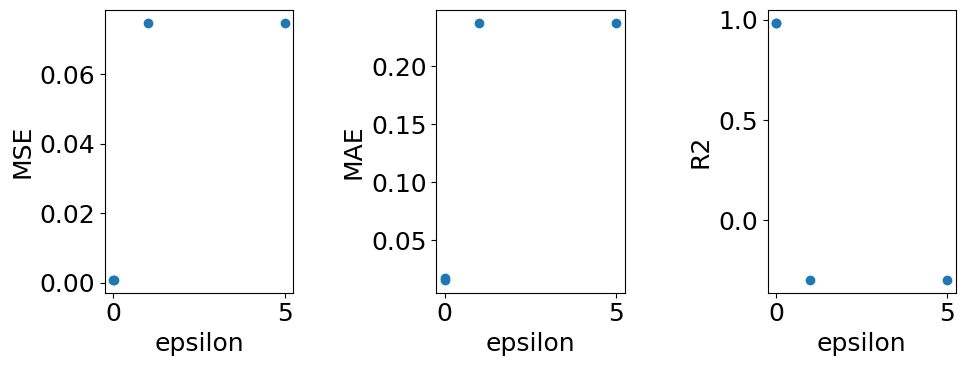

In [32]:
g=0.2
gamma_index2 = [i for i, x in enumerate(gamma_list.to_numpy()) if x == g]
print(gamma_index2)

c=100
c_index2 = [j for j, y in enumerate(c_list.to_numpy()) if y == c]
print(c_index2)

epsilon_index2=[]
for i in gamma_index2:
    for j in c_index2:
        if i==j:
            epsilon_index2.append(i)
print(epsilon_index2)

epsilon_val2=[]
mse_val2=[]
mae_val2=[]
r2_val2=[]
for indx in epsilon_index2:
    epsilon_val2.append(epsilon_list.iloc[indx])
    mse_val2.append(mse_list.iloc[indx])
    mae_val2.append(mae_list.iloc[indx])
    r2_val2.append(r2_list.iloc[indx])
    
epsilon_val2=pd.DataFrame(epsilon_val2, columns=['epsilon'])
mse_val2=pd.DataFrame(mse_val2, columns=['MSE'])
mae_val2=pd.DataFrame(mae_val2, columns=['MAE'])
r2_val2=pd.DataFrame(r2_val2, columns=['R2'])

gc_fix=pd.concat([epsilon_val2,mse_val2,mae_val2,r2_val2],axis=1)
display(gc_fix)

from pylab import*
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 4), tight_layout=True)

axs[0].scatter(epsilon_val2,mse_val2)
axs[1].scatter(epsilon_val2,mae_val2)
axs[2].scatter(epsilon_val2,r2_val2)

axs[0].set(xlabel='epsilon', ylabel='MSE')
axs[1].set(xlabel='epsilon', ylabel='MAE')
axs[2].set(xlabel='epsilon', ylabel='R2')

plt.show()

#### ***4.b.i.*** Influence of <code>gamma</code>

<div class="intro">

We fix <code>epsilon=0.01</code> and <code>C=100</code>.

Within this range, <code>epsilon=0.5</code> value minimizes the error and maximizes $R^2$.</div>

[1, 5, 9, 13, 17, 21, 25, 29, 33, 37, 41, 45, 49, 53, 57, 61]
[12, 13, 14, 15, 28, 29, 30, 31, 44, 45, 46, 47, 60, 61, 62, 63]
[13, 29, 45, 61]


,gamma,MSE,MAE,R2
13,0.1,0.000937,0.018406,0.983774
29,0.2,0.000821,0.017110,0.985776
45,0.5,0.000884,0.017440,0.984691
61,1.0,0.001143,0.019192,0.980209


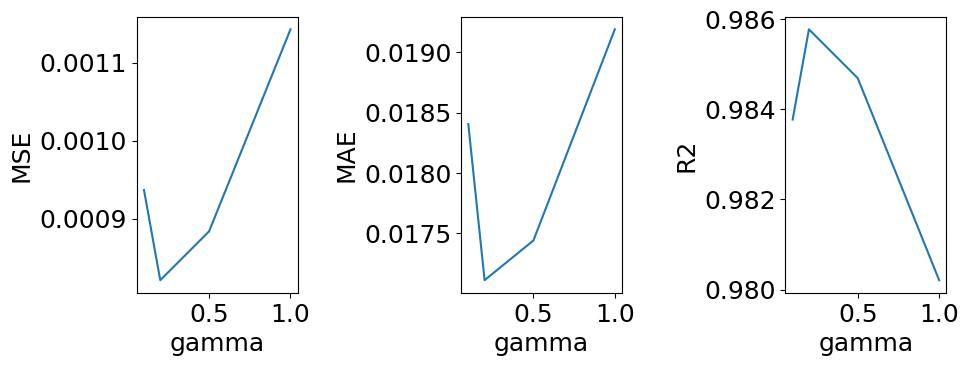

In [33]:
e=0.01
epsilon_index3 = [j for j, y in enumerate(epsilon_list.to_numpy()) if y == e]
print(epsilon_index3)

c=100
c_index3 = [j for j, y in enumerate(c_list.to_numpy()) if y == c]
print(c_index3)

gamma_index3=[]
for i in epsilon_index3:
    for j in c_index3:
        if i==j:
            gamma_index3.append(i)
print(gamma_index3)

gamma_val3=[]
mse_val3=[]
mae_val3=[]
r2_val3=[]
for indx in gamma_index3:
    gamma_val3.append(gamma_list.iloc[indx])
    mse_val3.append(mse_list.iloc[indx])
    mae_val3.append(mae_list.iloc[indx])
    r2_val3.append(r2_list.iloc[indx])
    
gamma_val3=pd.DataFrame(gamma_val3, columns=['gamma'])
mse_val3=pd.DataFrame(mse_val3, columns=['MSE'])
mae_val3=pd.DataFrame(mae_val3, columns=['MAE'])
r2_val3=pd.DataFrame(r2_val3, columns=['R2'])

ec_fix=pd.concat([gamma_val3,mse_val3,mae_val3,r2_val3],axis=1)
display(ec_fix)

from pylab import*
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 4), tight_layout=True)

axs[0].plot(gamma_val3,mse_val3)
axs[1].plot(gamma_val3,mae_val3)
axs[2].plot(gamma_val3,r2_val3)

axs[0].set(xlabel='gamma', ylabel='MSE')
axs[1].set(xlabel='gamma', ylabel='MAE')
axs[2].set(xlabel='gamma', ylabel='R2')

plt.show()

In [34]:
from pylab import *
print("BEST MSE")
bestMSE=metrics['MSE'].idxmin()
print(metrics.loc[bestMSE])
print()
print("BEST MAE")
bestMAE=metrics['MAE'].idxmin()
print(metrics.loc[bestMAE])
print()
print("BEST R2")
bestR2=metrics['R2'].idxmax()
print(metrics.loc[bestR2])

BEST MSE
gamma        0.200000
C          100.000000
epsilon      0.010000
MSE          0.000821
MAE          0.017110
R2           0.985776
Name: 29, dtype: float64

BEST MAE
gamma        0.500000
C          100.000000
epsilon      0.001000
MSE          0.000907
MAE          0.015560
R2           0.984282
Name: 44, dtype: float64

BEST R2
gamma        0.200000
C          100.000000
epsilon      0.010000
MSE          0.000821
MAE          0.017110
R2           0.985776
Name: 29, dtype: float64


In [25]:
# works best for large C and small epsilon, gamma value has been more or less balanced by the previous tuning

# gamma_values=[0.5]
# c_values=[1000]
# epsilon_values=[0.00001,0.0001,0.001]

In [26]:
# gamma_list2=[]
# c_list2=[]
# epsilon_list2=[]
# mse_list2=[]
# mae_list2=[]
# r2_list2=[]

# for gam in gamma_values:
#     for ce in c_values:
#         for eps in epsilon_values:
#             regressor = SVR(kernel = 'rbf', epsilon=eps, C=ce,gamma=gam)
#             regressor.fit(X_train, y_train.values.ravel())
#             y_pred=regressor.predict(X_test)
#             print("gamma= ", gam)
#             print("C= ", ce)
#             print("Epsilon= ", eps)
#             print()

#             mse=mean_squared_error(y_test,y_pred)
#             mae=mean_absolute_error(y_test,y_pred)
#             r2=r2_score(y_test,y_pred)
            
#             gamma_list2.append(gam)
#             c_list2.append(ce)
#             epsilon_list2.append(eps)
            
#             mse_list2.append(mse)
#             mae_list2.append(mae)
#             r2_list2.append(r2)

In [27]:
# gamma_list2=pd.DataFrame(gamma_list2, columns=['gamma'])
# c_list2=pd.DataFrame(c_list2, columns=['C'])
# epsilon_list2=pd.DataFrame(epsilon_list2, columns=['epsilon'])
# mse_list2=pd.DataFrame(mse_list2, columns=['MSE'])
# mae_list2=pd.DataFrame(mae_list2, columns=['MAE'])
# r2_list2=pd.DataFrame(r2_list2, columns=['R2'])

# metrics2=pd.concat([gamma_list2,c_list2,epsilon_list2,mse_list2,mae_list2,r2_list2],axis=1)

In [28]:
# metrics2.to_csv('metrics3ext.csv', encoding='utf-8', index=False)

In [29]:
# from pylab import*
# print("BEST MSE")
# bestMSE=metrics2['MSE'].idxmin()
# print(metrics2.loc[bestMSE])
# print()
# print("BEST MAE")
# bestMAE=metrics2['MAE'].idxmin()
# print(metrics2.loc[bestMAE])
# print()
# print("BEST R2")
# bestR2=metrics2['R2'].idxmax()
# print(metrics2.loc[bestR2])

## **5.** Fitting with best hyperparameters

<div class="rq"> <span style="color:red; font-weight:bold">Warning!!</span>
<br>This can be a time-consuming process, that takes almost 10mn with the proposed combination of hyperparameters.
</div>

In [15]:
from sklearn.svm import SVR
regressor1 = SVR(kernel = 'rbf', epsilon=0.001, C=100.0,gamma=0.5)
regressor1.fit(X_train, y_train.values.ravel())
y_pred=regressor1.predict(X_test)

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mse=mean_squared_error(y_test,y_pred)
mae=mean_absolute_error(y_test,y_pred)
r2=r2_score(y_test,y_pred)

print("MSE= ", mse)
print("MAE= ", mae)
print("R2= ", r2)

MSE=  0.0009073957473465629
MAE=  0.015560288341812572
R2=  0.9842818083928876


In [17]:
regressor2 = SVR(kernel = 'rbf', epsilon=0.001, C=100.0,gamma=0.5)
regressor2.fit(X_train, y_train.values.ravel())
ytrain_pred=regressor1.predict(X_train)

In [18]:
mset=mean_squared_error(y_train,ytrain_pred)
maet=mean_absolute_error(y_train,ytrain_pred)
r2t=r2_score(y_train,ytrain_pred)

print("MSE= ", mset)
print("MAE= ", maet)
print("R2= ", r2t)

MSE=  0.0005765122685647725
MAE=  0.010974562318247685
R2=  0.9895654491900912


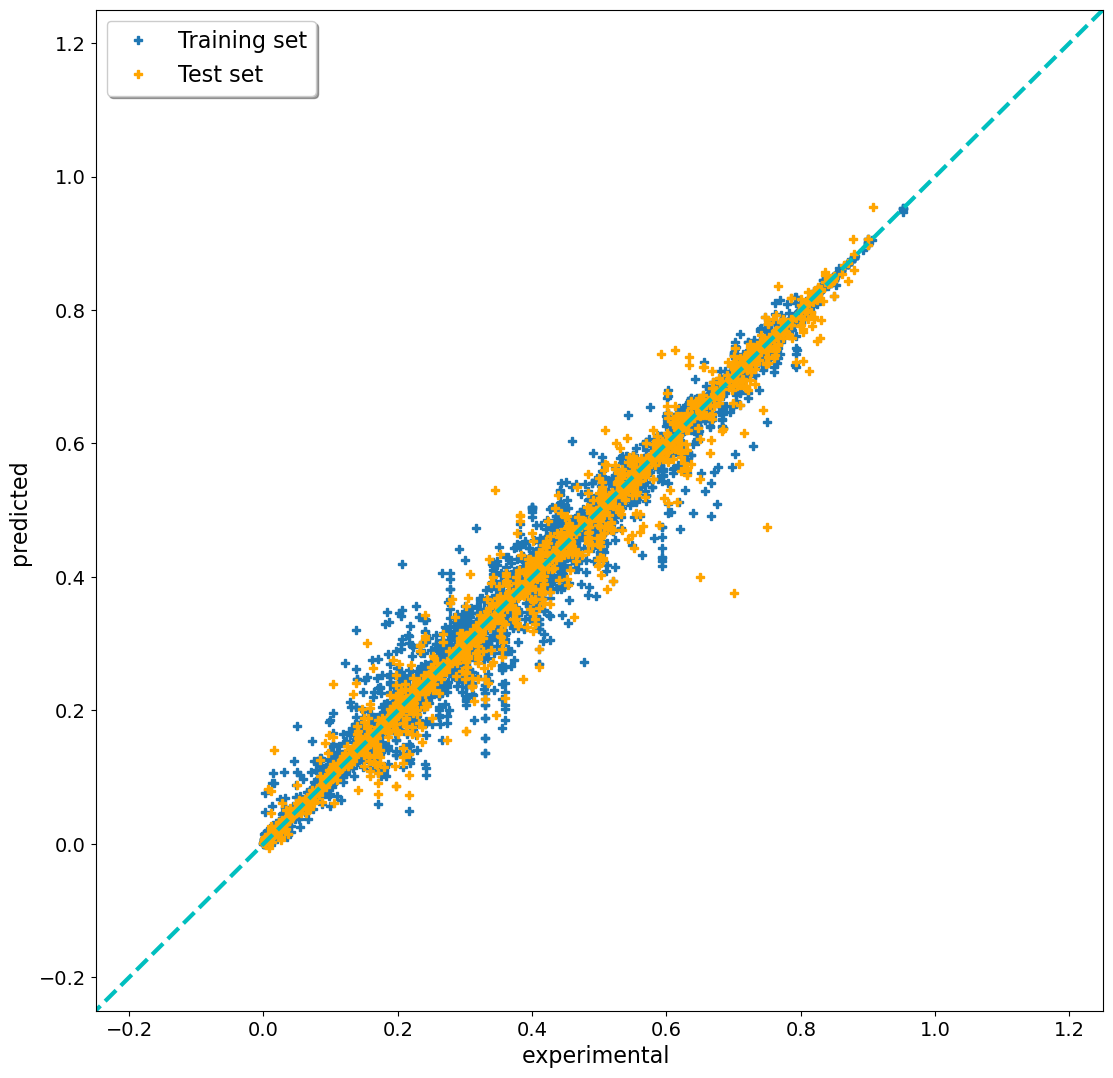

In [19]:
from pylab import *
xD=[-200,7000]
yD=[-200,7000]
fig = plt.figure(figsize=(13, 13))
plt.rcParams["font.size"] = (18) #font size
plt.tick_params(labelsize = 14)
plot(y_train,ytrain_pred,'P',color="#1f77b4",label='Training set')
plot(y_test,y_pred,'P',color="orange",label='Test set')
plot(xD,yD,'c',linestyle='--',lw=3)
xlabel('experimental ',fontsize=16)
ylabel('predicted ',fontsize=16)
xlim(-0.25,1.25);ylim(-0.25,1.25) 
#xlim(-3,150);ylim(-40,150) 
legend( shadow=True, fontsize='16')

## **6.** Error distribution

In [20]:
diffytest=y_pred-y_test
diffytrain=ytrain_pred-y_train

[Text(0, 0.5, '')]

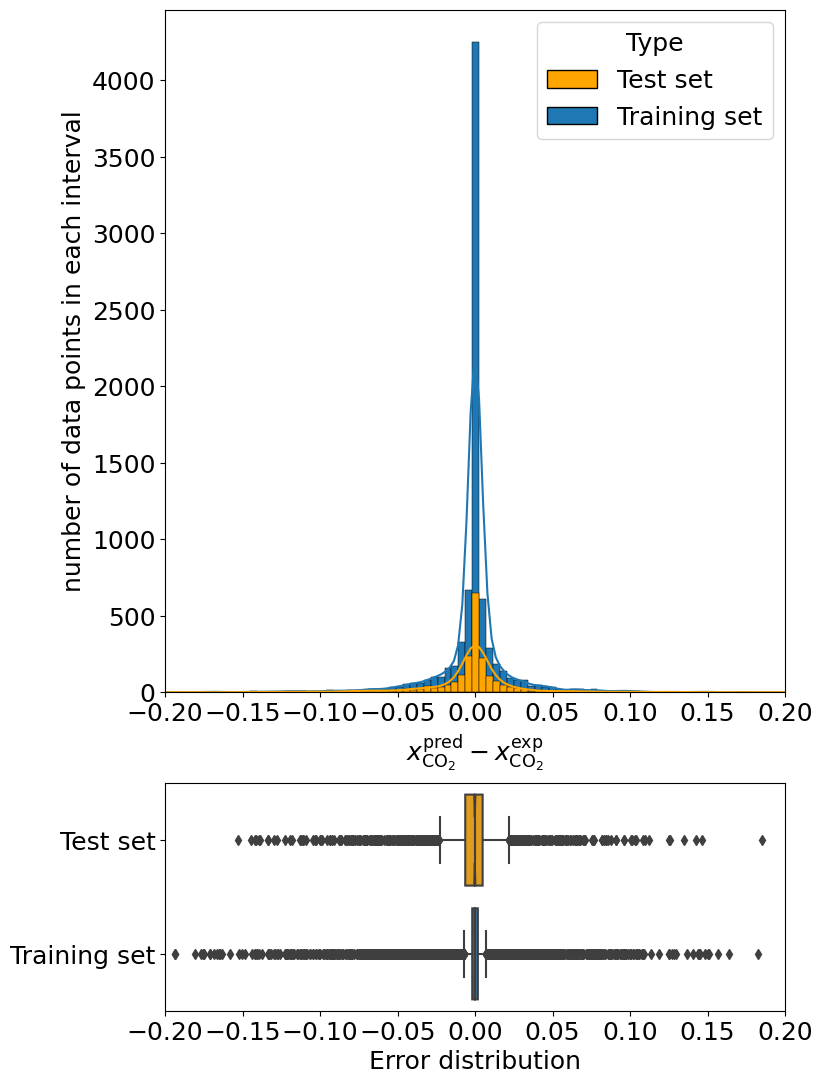

In [21]:
import matplotlib.gridspec as gridspec
xlim=0.2
nbins=120

df1 = pd.DataFrame(
    {
        "Error distribution": diffytest,
        "Type": 'Test set'    },
)
#display(df1)
df2 = pd.DataFrame(
    {
        "Error distribution": diffytrain,
        "Type": 'Training set'    },
)
distrib=pd.concat([df1,df2],ignore_index=True)
plt.rcParams["figure.figsize"] = (8,13) #graphic size
plt.rcParams["font.size"] = (18) #font size
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
plt.subplot(gs[0])
fig1=sb.histplot(data=distrib,x="Error distribution", hue="Type", bins=nbins, kde=True,palette=['Orange','#1f77b4'], alpha=1.0)
plt.xlabel("$x_{\mathrm{CO_2}}^{\mathrm{pred}}-x_{\mathrm{CO_2}}^{\mathrm{exp}}$")
plt.ylabel("number of data points in each interval")
plt.xlim(-xlim,xlim)
plt.subplot(gs[1])
plt.xlim(-xlim,xlim)
fig2=sb.boxplot(data=distrib, x="Error distribution", y="Type",notch=True, orient = 'h',palette=['Orange','#1f77b4'])
plt.xlabel("Error distribution")
fig2.set(ylabel=None)

In [22]:
vID.end(cwd0)

**End at:** Wednesday 17 May 2023, 16:21:27  
**Duration:** 00:13:24 078ms

<p style="text-align: center"><img width="800px" src="./config/svg/logoEnd.svg" style="margin-left:auto; margin-right:auto"/></p>